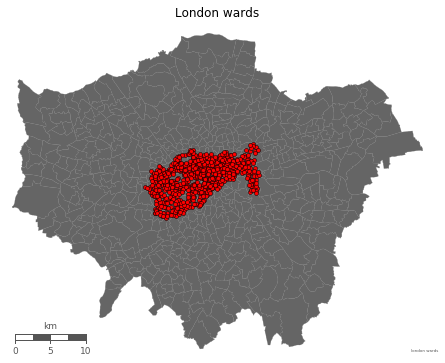

In [27]:
%matplotlib inline
from lxml import etree
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from matplotlib.collections import PatchCollection
from mpl_toolkits.basemap import Basemap
from shapely.geometry import Point, Polygon, MultiPoint, MultiPolygon
from shapely.prepared import prep
from pysal.esda.mapclassify import Natural_Breaks as nb
from descartes import PolygonPatch
from itertools import chain
import fiona 
import csv 


datapath_feed = 'Y:\\okofm\\tfl\\data\\'

data2 = pd.read_csv(datapath_feed + 'tfl 2016_09_16_11_17.csv')
df = data2[['name', 'lat', 'long']]

# Create empty lists for the data we are interested in.
lats, lons = [], []
magnitudes = []

filename = datapath_feed + 'tfl 2016_09_16_11_17.csv'

# Read through the entire file, skip the first line,
#  and pull out just the lats and lons.
with open(filename) as f:
    # Create a csv reader object.
    reader = csv.reader(f)
    
    # Ignore the header row.
    next(reader)
    
    # Store the latitudes and longitudes in the appropriate lists.
    for row in reader:
        lats.append(float(row[4]))
        lons.append(float(row[5]))

shp = fiona.open(datapath_feed + 'london_wards.shp')    #open the shapefile
bds = shp.bounds    #extract map boundaries
shp.close()
extra = 0.01

#calculate the extent, width, and height of our basemap
ll = (bds[0], bds[1])
ur = (bds[2], bds[3])
coords = list(chain(ll, ur))
w, h = coords[2]-coords[0], coords[3]-coords[1]

#we create a basemap instance
m = Basemap(
    projection='tmerc',
    lon_0 = np.average([bds[0],bds[2]]),
    lat_0 = np.average([bds[1],bds[3]]),
    #lon_0=-2.,    #central longitude
    #lat_0=49.,    #central latitude
    ellps = 'WGS84',
    llcrnrlon=coords[0] - extra * w,    #longitude of lower-left corner of the desired map domain
    llcrnrlat=coords[1] - extra + 0.01 * h,    #Latitude of lower-left corner of the desired map domain
    urcrnrlon=coords[2] + extra * w,    #Longitude of upper-right corner of the desired map domain
    urcrnrlat=coords[3] + extra + 0.01 * h,    #Latitude of upper-right corner of the desired map domain
    lat_ts=0,
    resolution='i',
    suppress_ticks=True)

m.readshapefile(
    datapath_feed +'london_wards',
    'london',
    color='none',
    zorder=2)

# set up a map dataframe
df_map = pd.DataFrame({
    'poly': [Polygon(xy) for xy in m.london],
    'ward_name': [ward['NAME'] for ward in m.london_info]})

df_map['area_m'] = df_map['poly'].map(lambda x: x.area)
df_map['area_km'] = df_map['area_m'] / 100000

# Create Point objects in map coordinates from dataframe lon and lat values
map_points = pd.Series(
    [Point(m(mapped_x, mapped_y)) for mapped_x, mapped_y in zip(df['long'], df['lat'])])
plaque_points = MultiPoint(list(map_points.values))
wards_polygon = prep(MultiPolygon(list(df_map['poly'].values)))
# calculate points that fall within the London boundary
ldn_points = filter(wards_polygon.contains, plaque_points)

# draw ward patches from polygons
df_map['patches'] = df_map['poly'].map(lambda x: PolygonPatch(
    x,
    fc='#555555',
    ec='#787878', lw=.25, alpha=.9,
    zorder=4))

plt.clf()
fig = plt.figure()
ax = fig.add_subplot(111, axisbg='w', frame_on=False)

'''# we don't need to pass points to m() because we calculated using map_points and shapefile polygons
dev = m.scatter(
    [geom.x for geom in ldn_points],
    [geom.y for geom in ldn_points],
    5, marker='o', lw=.25,
    facecolor='#33ccff', edgecolor='w',
    alpha=0.9, antialiased=True,
    label='Blue Plaque Locations', zorder=3)'''
# plot boroughs by adding the PatchCollection to the axes instance
ax.add_collection(PatchCollection(df_map['patches'].values, match_original=True))
# copyright and source data info
smallprint = ax.text(
    1.03, 0,
    'london wards',
    ha='right', va='bottom',
    size=4,
    color='#555555',
    transform=ax.transAxes)

# Draw a map scale
m.drawmapscale(
    coords[0] + 0.08, coords[1] + 0.015,
    coords[0], coords[1],
    10.,
    barstyle='fancy', labelstyle='simple',
    fillcolor1='w', fillcolor2='#555555',
    fontcolor='#555555',
    zorder=5)
plt.title("London wards")
plt.tight_layout()
# this will set the image width to 722px at 100dpi
fig.set_size_inches(7.22, 5.25)
plt.savefig('data/london_plaques.png', dpi=100, alpha=True)

x,y = m(lons, lats)
m.plot(x, y, 'ro', markersize=4)

plt.show()